# Importando bibliotecas

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

# Carregando base de dados

In [112]:
df = pd.read_csv('dataset/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [114]:
## Retirando algumas coluna indesejadas
df = df.iloc[:, 1:df.shape[1]-1]

In [115]:
## Divindo entre rótulos e previsores
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

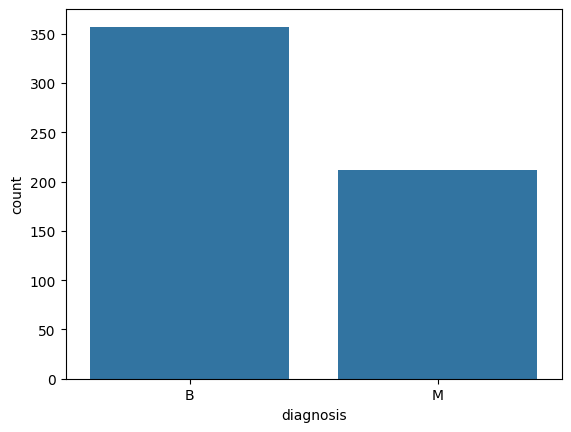

In [116]:
## Plotando a contagem de rótulos
sns.barplot(y.value_counts());

In [117]:
## trocando nome dos rótulos para valores númericos
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

## Escalando os dados previsóres
mms = MinMaxScaler()
X = mms.fit_transform(X)

<Figure size 1800x800 with 0 Axes>

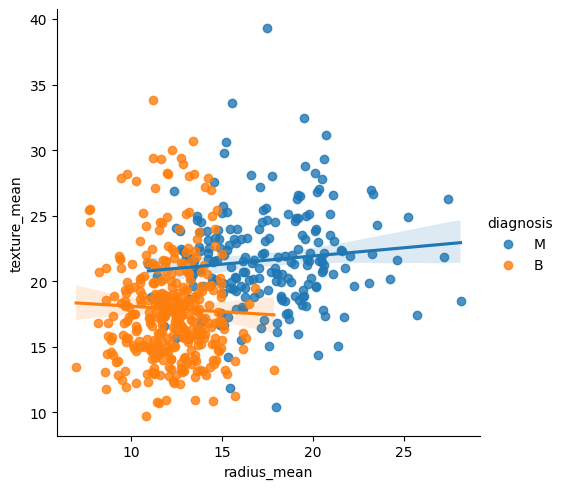

In [118]:
plt.figure(figsize=(18, 8))
sns.lmplot(x='radius_mean', y='texture_mean', hue='diagnosis', data=df);

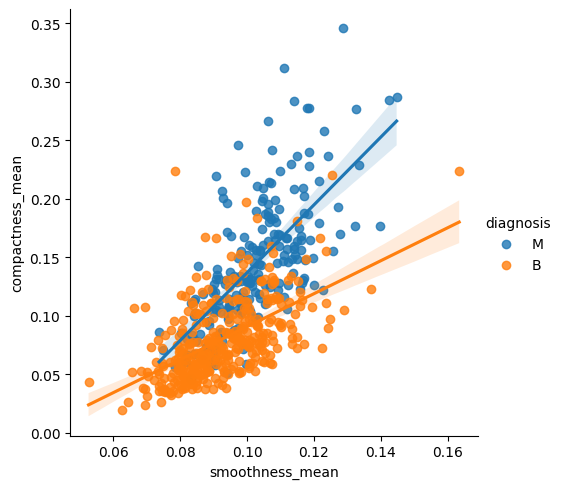

In [119]:
sns.lmplot(x ='smoothness_mean', y = 'compactness_mean',  
           data = df, hue = 'diagnosis') 

## Criando Modelo e avaliando modelo

In [120]:
scoring = {}
for n in range(1, 50, 2):
    scoring[n] = []
    knc = KNeighborsClassifier(n_neighbors=n)
    for i in range(1, X.shape[1]):
        skb = SelectKBest(chi2, k=i)
        X_filtred = skb.fit_transform(X, y)
        cv = cross_val_score(
            knc,
            X_filtred,
            y,
            scoring='accuracy',
            n_jobs=-1
        )
        ## Retorna n_features, n_neighbors, mean_acc, std
        scoring[n].append((i, n, cv.mean(), cv.std()))

In [121]:
max_acc = {
    'n_neighbors': 0,
    'n_features': 0,
    'accuracy': 0,
    'std_acc': 0,
}
for k, t in scoring.items():
    for v in t:
        if v[2] > max_acc['accuracy']:
            max_acc['n_features'] = v[0]
            max_acc['n_neighbors'] = v[1]
            max_acc['accuracy'] = v[2]
            max_acc['std_acc'] = v[3]

In [122]:
## Então dentre eles encontramos o modelo com melhor accuracy, agora vamos avaliar sua precision e recall para cada uma das classes
## Para isso vamos criar um novo modelo com os parametros da melhor seleção e utilizar para avaliar
print(max_acc)

{'n_neighbors': 11, 'n_features': 28, 'accuracy': 0.971914299021891, 'std_acc': 0.012868827412374747}


## Criando o modelo com os melhores parametros

In [123]:
## Selecionando os melhores atributos
skb = SelectKBest(chi2, k=28)
X_filtred = skb.fit_transform(X, y)

In [132]:
## Criando e avaliando modelo
skf = StratifiedKFold(n_splits=5)
cms = []
for i, (train_index, test_index) in enumerate(skf.split(X_filtred, y)):
    X_train, y_train, X_test, y_test = X_filtred[train_index], y[train_index], X_filtred[test_index], y[test_index]
    knn = KNeighborsClassifier(n_neighbors=11)
    knn.fit(X_train, y_train)
    predicts = knn.predict(X_test)
    cm = confusion_matrix(y_test, predicts)
    cms.append(cm)
cm_mean = np.mean(cms, axis=0)

In [133]:
## Avaliando recall e precision do modelo

## Precision e recall label 0
recall_0 = cm_mean[0][0] / sum(cm_mean[0])
precision_0 = cm_mean[0][0] / sum(cm_mean[:, 0])

## Precision e recall label 1
recall_1 = cm_mean[1][1] / sum(cm_mean[1])
precision_1 = cm_mean[1][1] / sum(cm_mean[:, 1])

print(f'Classe {le.inverse_transform([0])[0]}')
print(f'Precision: {precision_0}')
print(f'Recall: {recall_0}')

print(f'Classe {le.inverse_transform([1])[0]}')
print(f'Precision: {precision_1}')
print(f'Recall: {recall_1}')

Classe B
Precision: 0.9595687331536388
Recall: 0.9971988795518207
Classe M
Precision: 0.9949494949494949
Recall: 0.9292452830188679


In [129]:
# O Modelo obteve ótimos resultados

#Accuracy: 0.971914299021891

#Classe B
#Precision: 0.9595687331536388
#Recall: 0.9971988795518207

#Classe M
#Precision: 0.9949494949494949
#Recall: 0.9292452830188679